In [23]:
import torch
import sys
import json
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

from src.dataset import ECommerceDS
from src.metrics import compute_recall_at_k, compute_mrr
from src.metric_handler import MetricHandler

sys.path.append("src/")
from models.bert4rec import BERT4Rec

In [24]:
product2token_fp = "data/product2token.json"
weight_fp = "results/bert_tlab_nope/best_model.pth"
device = "mps"
test_ds_fp = "data/splits/test.jsonl"
output_dir = 'results/bert_tlab_nope/test_results'
N = 10 # num bins

os.makedirs(output_dir, exist_ok=True)

In [25]:
with open(product2token_fp, mode="r") as f:
    product2token = json.load(f)

In [26]:
model = BERT4Rec(
    vocab_size=len(product2token),
    hidden=128,
    n_layers=4,
    attn_heads=4,
    pe_type="nope"
)
model.load_state_dict(torch.load(weight_fp))
model.to(device)
model.eval()
print("Loaded model weights")

>> Not using positional embeddings


/var/folders/1n/tpv7t5v15pd7j42g_46lx79w0000gn/T/ipykernel_37233/470870655.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_fp))


Loaded model weights


In [27]:
test_ds = ECommerceDS(test_ds_fp, max_len=50, product2token=product2token, mask="last")
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [28]:
print(test_ds[0]["products"])
print(test_ds[0]["alibi"][-1])
print(test_ds[0]["alibi"][-1][test_ds[0]["attention_mask"]==1])
print(-torch.diff(test_ds[0]["alibi"][-1][test_ds[0]["attention_mask"]==1]))
print(torch.var(-torch.diff(test_ds[0]["alibi"][-1][test_ds[0]["attention_mask"]==1])))
# print((-torch.diff(test_ds[0]["alibi"][-1])))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 4, 5,
        5, 6])
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        31., 15., 15., 13.,  8.,  4.,  2.,  0.])
tensor([31., 15., 15., 13.,  8.,  4.,  2.,  0.])
tensor([16., -0.,  2.,  5.,  4.,  2.,  2.])
tensor(28.6190)


In [29]:
all_logits = list()
all_labels = list()
all_time_vars = list()
all_time_avgs = list()

with torch.no_grad():  # Disable gradient computation for evaluation
    for test_batch in tqdm(test_dl):
        x_test = test_batch["masked_products"].to(device)
        labels_test = test_batch["products"].to(device)
        cloze_mask_test = test_batch["cloze_mask"].to(device)
        alibi = test_batch["alibi"].to(device)
        attention_mask = test_batch["attention_mask"].to(device)

        logits_test = model(x_test, alibi=alibi)

        logits_flat_test = logits_test.view(-1, logits_test.shape[-1])
        labels_flat_test = labels_test.view(-1)
        cloze_mask_flat_test = cloze_mask_test.view(-1)

        # Select only the masked positions
        valid_indices_test = cloze_mask_flat_test == 1
        logits_masked_test = logits_flat_test[valid_indices_test] # B x V
        labels_masked_test = labels_flat_test[valid_indices_test] # B

        all_logits.append(logits_masked_test)
        all_labels.append(labels_masked_test)
        time_vars = list()
        time_avgs = list()
        for i in range(labels_masked_test.shape[0]):
            time_var = torch.var(-torch.diff(alibi[i][-1][attention_mask[i]==1]))
            time_avg = torch.mean(-torch.diff(alibi[i][-1][attention_mask[i]==1]))
            time_vars.append(time_var)
            time_avgs.append(time_avg)
        time_vars = torch.tensor(time_vars)
        all_time_vars.append(time_vars)
        all_time_avgs.append(time_avgs)

100%|██████████| 700/700 [07:53<00:00,  1.48it/s]


In [30]:
# results_dict = {
#     "idx": list(),
#     "time_var": list(),
#     "label": list(),
#     "top_20": list(),
# }

# counter = 0
# for i in tqdm(range(len(all_logits))):
#     logits = all_logits[i]
#     labels = all_labels[i]
#     time_vars = all_time_vars[i]

#     for j in range(len(logits)):
#         results_dict["idx"].append(counter)
#         results_dict["time_var"].append(time_vars[j].item())
#         results_dict["label"].append(labels[j].item())
#         results_dict["top_20"].append(torch.topk(logits, 20)[1].tolist())

#         counter += 1

In [31]:
# Pre-allocate the lists for the results
idx_list = []
time_var_list = []
time_avg_list = []
label_list = []
top_20_list = []

counter = 0

# Vectorized processing: compute top-20 indices once per batch
for i in tqdm(range(len(all_logits))):
    logits = all_logits[i]
    labels = all_labels[i]
    time_vars = all_time_vars[i]
    time_avgs = all_time_avgs[i]

    # Compute top 20 indices for the whole logits tensor at once
    top_20_indices = torch.topk(logits, 20, dim=-1)[1]

    # Add all elements to the lists
    batch_size = len(logits)
    idx_list.extend([counter + k for k in range(batch_size)])
    time_var_list.extend([time_vars[k].item() for k in range(batch_size)])
    time_avg_list.extend([time_avgs[k].item() for k in range(batch_size)])
    label_list.extend([labels[k].item() for k in range(batch_size)])
    top_20_list.extend(top_20_indices.tolist())

    # Update counter
    counter += batch_size

# After the loop, assign the results to the dictionary
results_dict = {
    "idx": idx_list,
    "time_var": time_var_list,
    "time_avg": time_avg_list,
    "label": label_list,
    "top_20": top_20_list
}

100%|██████████| 700/700 [01:38<00:00,  7.12it/s]


In [32]:
df = pd.DataFrame(results_dict)
df.to_csv(os.path.join(output_dir, "test_output.csv"), index=False)

In [33]:
df = pd.read_csv(os.path.join(output_dir, "test_output.csv"))
df['top_20'] = df['top_20'].apply(ast.literal_eval)

In [34]:
df.head()

,idx,time_var,time_avg,label,top_20
0,0,28.619045,4.428572,6,"[2, 5, 3, 124, 10, 139, 12, 9, 13, 31, 32, 80,..."
1,1,9.982143,1.625000,11,"[10, 9, 8, 12494, 555, 834, 3372, 20299, 5864,..."
2,2,0.285714,0.500000,12,"[12, 9, 14, 2, 32, 13, 10, 31, 124, 80, 81, 3,..."
3,3,236.897461,12.692308,12,"[24, 23, 19, 197, 22, 196, 18, 36, 46, 16, 107..."
4,4,4.736394,1.183674,39,"[39, 23, 38, 40, 35, 55, 19, 43, 107, 30, 24, ..."


In [35]:
# Function to compute recall at K
def recall_at_k(row, k):
    return int(row['label'] in row['top_20'][:k])

# Function to compute MRR for a single row
def mrr(row):
    try:
        # Find the rank of the correct label in top_20
        rank = row['top_20'].index(row['label']) + 1
        return 1 / rank
    except ValueError:
        return 0  # If label is not in top_20, return 0

# Compute recall@1, recall@5, recall@10, recall@15, recall@20, and MRR
df['recall@1'] = df.apply(recall_at_k, k=1, axis=1)
df['recall@5'] = df.apply(recall_at_k, k=5, axis=1)
df['recall@10'] = df.apply(recall_at_k, k=10, axis=1)
df['recall@20'] = df.apply(recall_at_k, k=20, axis=1)
df['mrr'] = df.apply(mrr, axis=1)

In [36]:
df.head()

,idx,time_var,time_avg,label,top_20,recall@1,recall@5,recall@10,recall@20,mrr
0,0,28.619045,4.428572,6,"[2, 5, 3, 124, 10, 139, 12, 9, 13, 31, 32, 80,...",0,0,0,0,0.0
1,1,9.982143,1.625000,11,"[10, 9, 8, 12494, 555, 834, 3372, 20299, 5864,...",0,0,0,0,0.0
2,2,0.285714,0.500000,12,"[12, 9, 14, 2, 32, 13, 10, 31, 124, 80, 81, 3,...",1,1,1,1,1.0
3,3,236.897461,12.692308,12,"[24, 23, 19, 197, 22, 196, 18, 36, 46, 16, 107...",0,0,0,0,0.0
4,4,4.736394,1.183674,39,"[39, 23, 38, 40, 35, 55, 19, 43, 107, 30, 24, ...",1,1,1,1,1.0


In [37]:
df.to_csv(os.path.join(output_dir, "test_output.csv"), index=False)

In [38]:
total_results = {
    "test_recall@1": df["recall@1"].mean(),
    "test_recall@5": df["recall@5"].mean(),
    "test_recall@10": df["recall@10"].mean(),
    "test_recall@20": df["recall@20"].mean(),
    "test_mrr": df["mrr"].mean()
}
total_results = {k: [v] for k, v in total_results.items()}
total_result_df = pd.DataFrame(total_results)
total_result_df.to_csv(os.path.join(output_dir, "total_results.csv"), index=False)

### Performance vs. Time Delta Average (this figure is better than the one below imo)
- time delta average = average # of days between consecutive purchases
- I think this figure is better bc the time delta average makes more intuitive sense

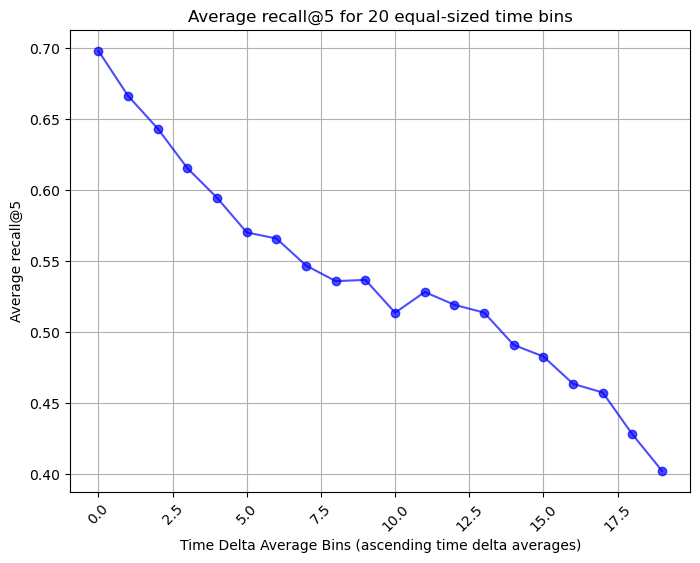

In [39]:
# Assuming df is your DataFrame
# Sort the DataFrame by 'time_var' (if not already sorted)
df_sorted = df.sort_values(by='time_avg')

# Define the number of bins (N)
N = 20

# Create quantile-based bins (equal number of samples per bin)
bins = pd.qcut(df_sorted['time_avg'], q=N, labels=False)

# Group by the bins and calculate the mean of 'recall@5' for each bin
bin_means = df_sorted.groupby(bins)['recall@5'].mean()

# Plot the means as a line plot
plt.figure(figsize=(8, 6))
bin_means.plot(kind='line', marker='o', linestyle='-', color='b', alpha=0.7)

# Add labels and title
plt.title(f"Average recall@5 for {N} equal-sized time bins")
plt.xlabel("Time Delta Average Bins (ascending time delta averages)")
plt.ylabel("Average recall@5")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

### Performance vs. Time Delta Variation
time delta variation = variance in # of days between consecutive purchases

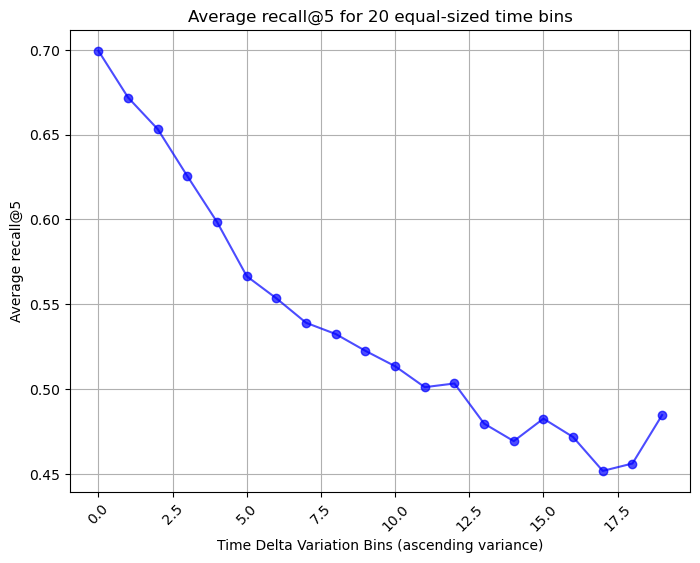

In [40]:
# Assuming df is your DataFrame
# Sort the DataFrame by 'time_var' (if not already sorted)
df_sorted = df.sort_values(by='time_var')

# Define the number of bins (N)
N = 20

# Create quantile-based bins (equal number of samples per bin)
bins = pd.qcut(df_sorted['time_var'], q=N, labels=False)

# Group by the bins and calculate the mean of 'recall@5' for each bin
bin_means = df_sorted.groupby(bins)['recall@5'].mean()

# Plot the means as a line plot
plt.figure(figsize=(8, 6))
bin_means.plot(kind='line', marker='o', linestyle='-', color='b', alpha=0.7)

# Add labels and title
plt.title(f"Average recall@5 for {N} equal-sized time bins")
plt.xlabel("Time Delta Variation Bins (ascending variance)")
plt.ylabel("Average recall@5")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [41]:
# results_dict

In [42]:
# all_logits_tensor = torch.concat(all_logits, dim=0)
# all_labels_tensor = torch.concat(all_labels, dim=0)
# all_time_vars_tensor = torch.concat(all_time_vars, dim=0)

# print(all_logits_tensor.shape)
# print(all_labels_tensor.shape)
# print(all_time_vars_tensor.shape)

In [43]:
# metric_handler = MetricHandler("results/bert_baseline")

#  # Calculate validation loss and metrics
# test_loss = F.cross_entropy(logits_masked_test, labels_masked_test)
# batch_metrics = {
#     "test_loss": test_loss.item(),
#     "test_recall@1": compute_recall_at_k(logits_masked_test, labels_masked_test, k=1),
#     "test_recall@5": compute_recall_at_k(logits_masked_test, labels_masked_test, k=5),
#     "test_recall@10": compute_recall_at_k(logits_masked_test, labels_masked_test, k=10),
#     "test_recall@20": compute_recall_at_k(logits_masked_test, labels_masked_test, k=20),
#     "test_mrr": compute_mrr(logits_masked_test, labels_masked_test),
# }
# metric_handler.batch_update(batch_metrics)

# metric_handler.all_update_save_clear(save_name="test_results.csv")

### Next steps
- performance vs time variation
- by category

In [44]:
# test_ds[0]